In [1]:
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import os
import itertools
import matplotlib as plt

from sklearn.metrics import silhouette_score as sil_score
from sklearn.cluster import KMeans 

In [2]:
from scipy.stats import ttest_ind
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder


In [3]:
def demo(mn,mp):
    stud_info= pd.read_csv(r'../../oulad_data/studentInfo.csv')
    stud_info=stud_info.loc[(stud_info['code_module']==mn) & (stud_info['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)
    #return stud_info.drop(['code_module','code_presentation','final_result'],axis=1).set_index('id_student')
    return stud_info.set_index('id_student')

In [ ]:
del demo

In [ ]:
# mn='FFF'
# mp='2014B'
# reg = pd.read_csv(r'../../oulad_data/studentRegistration.csv')
# regs=reg.loc[(reg['code_module']==mn) & (reg['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)
# stud_info= pd.read_csv(r'../../oulad_data/studentInfo.csv')
# si=stud_info.loc[(stud_info['code_module']==mn) & (stud_info['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)
# len(reg),len(regs),len(stud_info),len(si)
si.head(2)

In [4]:
def studInfo(mn,mp,remove_withdraw=False,only_ids=True):
    reg = pd.read_csv(r'../../oulad_data/studentRegistration.csv')
    stud_info= pd.read_csv(r'../../oulad_data/studentInfo.csv')
    courses=pd.read_csv('../../oulad_data/courses.csv')
    module_len=courses.loc[(courses['code_module']==mn) & (courses['code_presentation']==mp)]['module_presentation_length'].item()+1
    regs=reg.loc[(reg['code_module']==mn) & (reg['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)
    si=stud_info.loc[(stud_info['code_module']==mn) & (stud_info['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)
    info=regs.merge(si,on='id_student',how='left')
    info['date_unregistration']=info['date_unregistration'].replace(np.nan,module_len+1)
    info=info.loc[info['date_unregistration']>0]
    if remove_withdraw:
        info=info.loc[info['final_result']!='Withdrawn']
    if only_ids:
        return info['id_student'].tolist(),info[['id_student','final_result']].set_index('id_student'),module_len
    return info,_,module_len


In [ ]:
del studInfo

In [5]:
def vle(mn,mp,stud_ids,combine=True):
    vle=pd.read_csv(r'../../oulad_data/vle.csv')
    dir_name='../../moduleVles/'
    format='.csv'
    n=mn[0]+mp[2:]
    cols=['code_module','code_presentation','id_student','id_site','date','sum_click']
    p=os.path.join(dir_name, n + format)
    mbeh=pd.read_csv(p,usecols=cols)
    mbeh=mbeh.loc[mbeh['date']>=0].drop(['code_module','code_presentation'],axis=1)
    mbeh=mbeh.loc[mbeh['id_student'].isin(stud_ids)]
    mvle=vle.loc[(vle['code_module']==mn) & (vle['code_presentation']==mp)].copy()
    mvle.drop(['week_from','week_to','code_module','code_presentation'],axis=1,inplace=True)
    mclicks = mbeh.merge(mvle,on='id_site')#.drop(['id_site'],axis=1)
    
    activities = mclicks.groupby(by='id_student').count().reset_index()
    activities = activities.drop(columns=['date','sum_click','activity_type'])
    
    date_grouped = mclicks.groupby(by=['id_student','date']).count().reset_index()
    days_studied = date_grouped.groupby(by='id_student').count().reset_index()
    days_studied = days_studied.drop(columns=['id_site','sum_click','activity_type'])
    
    mclicks = pd.pivot_table(mclicks, index=['id_student'], columns='activity_type',values='sum_click', aggfunc='sum', fill_value=0)
    if combine:
        mclicks['total_clicks']=mclicks.sum(axis=1)
        collab_types = ["forumng", "ouwiki", "oucollaborate", "ouelluminate"]
        course_struct_types = ["glossary", "homepage", "dataplus", "folder"]
        course_content_types = ["resource", "url", "oucontent", "page", "subpage", "sharedsubpage", "repeatactivity", "dualpane", "repeatactivity"]
        eval_types = ["quiz", "questionnaire", "externalquiz"]
        ct=[el for el in collab_types if el in mclicks.columns.values]
        cst=[el for el in course_struct_types if el in mclicks.columns.values]
        cct=[el for el in course_content_types if el in mclicks.columns.values]
        et=[el for el in eval_types if el in mclicks.columns.values]

        mclicks['collab']=mclicks[ct].sum(axis=1)
        mclicks['struct']=mclicks[cst].sum(axis=1)
        mclicks['content']=mclicks[cct].sum(axis=1)
        mclicks['eval']=mclicks[et].sum(axis=1)

        mclicks=mclicks[['collab','struct','content','eval','total_clicks']]
    return mclicks.join(days_studied.set_index('id_student')).join(activities.set_index('id_student'))
    #return mclicks,activities,days_studied

In [6]:
def get_assessments(mn,mp,stud_ids,ml,cma_drop=False,days_count=False):#withdraw=False stud_info['id_student'].tolist()
    assessments=pd.read_csv('../../oulad_data/assessments.csv')
    studentAssessment = pd.read_csv('../../oulad_data/studentAssessment.csv')
    ma=assessments.loc[(assessments['code_module']==mn) & (assessments['code_presentation']==mp)].drop(['code_module','code_presentation'],axis=1)# filter only assesemnts related to the module and presentation
    assessments_ids=ma.id_assessment.tolist()
    studAss=studentAssessment[(studentAssessment['id_assessment'].isin(assessments_ids)) & (studentAssessment['id_student'].isin(stud_ids))]#stud_info['id_student'].values.tolist()
    assessments= pd.merge(studAss, ma, how="left", on="id_assessment")
    if cma_drop:
        assessments=assessments.loc[assessments['assessment_type']=='TMA']
        ma=ma.loc[ma['assessment_type']=='TMA']
    #assessments.drop(['id_assessment'],1,inplace=True)
    assessments['asstype_date']=assessments['assessment_type']+assessments['date'].astype(int).map(str)
    #assessments.drop(['assessment_type'],1,inplace=True)
    assessments['late_submit'] = assessments.apply(lambda x: 0 if (x['date_submitted']<=x['date']) else 1, axis=1)
    #assessments['days_count'] = assessments.apply(days_count,axis=1)
    assessments['days_count'] = assessments.apply(lambda x: 0 if (x['date_submitted']<=0) else (x['date_submitted']),axis=1)
    ass_scores=pd.pivot_table(assessments, index=['id_student'],columns='asstype_date',values='score', aggfunc='first',fill_value=0)
    asstypes=assessments['asstype_date'].unique().tolist()
    tmas=[col for col in asstypes if 'TMA' in col]
    #tmas_days=[c+'_days' for c in tmas]
    tmas_cols=[]
    for i,v in enumerate(tmas):
        tmas_cols.append(v)
        tmas_cols.append(v+'_days')
    df = pd.DataFrame()
    df = pd.DataFrame(columns = ['id_student']+tmas_cols)
    for id_stud in stud_ids:#stud_info['id_student'].tolist()
        indiv_student_assess = assessments.loc[assessments.id_student == id_stud]
        dic={}
        dic['id_student']=id_stud
        for i,v in enumerate(tmas):
            tmp=indiv_student_assess.loc[indiv_student_assess['asstype_date']==v]
            if (tmp.empty):
                dic[v]=2
                dic[v+'_days']=ml+1
            else:
                dic[v]=tmp['late_submit'].item()
                dic[v+'_days']=tmp['days_count'].item()

        df = df.append(dic,ignore_index = True)
    #df['id_student']=df['id_student'].astype('int')
    df=df.apply(pd.to_numeric,downcast='integer')
    only_tmas=[col for col in df.columns if '_days' not in col]
    cdays=[c for c in df.columns.tolist() if '_days' in c]
#     if not days_count:
#         df=df[only_tmas].set_index('id_student')
    df['avg_days']=df[cdays].mean(axis=1)
    df=df[['id_student']+tmas+['avg_days']].set_index('id_student')
    return df,ass_scores
    

In [ ]:
del get_assessments

In [7]:
def kmeans(data):
    clusts={}
    ks=[2,3,5]
    for k in ks:
        dic={}
        kmeans = KMeans(n_clusters=k, max_iter=25, verbose=0) # initialization
        kmeans.fit(data)
        clusters=kmeans.predict(data)
        dic['clusters']=pd.DataFrame(clusters,index=data.index, columns=[k])#columns=["Cluster"+str(k)]
        dic['centroids']=pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
        dic['sil']=sil_score(data,clusters)
        clusts[k]=dic
    return clusts

In [ ]:
'''
def results_per_cluster(clusts_ds, c):
    #dic_count={}
    perc_dict={}
    for v in range(c):
        tmp_dict={}
        samps=clusts_ds.loc[clusts_ds[c]==v]['final_result'].value_counts().to_dict()
        s=sum(samps.values())
        for k, val in samps.items():
            tmp_dict[k]=round(val*100/s,2)    
        #dic_count[v]=tmp_dict
        perc_dict[v]=[tmp_dict.get('Pass',0)+tmp_dict.get('Distinction',0),tmp_dict.get('Fail',0)+tmp_dict.get('Withdrawn',0)]
        #perc_dict[v]['f']=tmp_dict['Fail']+tmp_dict['Withdrawn']
    return perc_dict
'''

In [8]:
def clust_results(df, c):
    #dic_count={}
    perc_dict={}
    for v in range(c):
        tmp_dict={}
        #samps=clusts_ds.loc[clusts_ds[c]==v]['final_result'].value_counts().to_dict()
        samps=df.loc[df[c]==v]['final_result'].value_counts().to_dict()
        s=sum(samps.values())
        for k, val in samps.items():
            tmp_dict[k]=round(val*100/s,2)    
        #dic_count[v]=tmp_dict
        perc_dict[v]=[tmp_dict.get('Pass',0)+tmp_dict.get('Distinction',0),tmp_dict.get('Fail',0)]
        #perc_dict[v]['f']=tmp_dict['Fail']+tmp_dict['Withdrawn']
    return perc_dict


In [9]:
def are_centers_different(ar1,ar2):
    s,p=ttest_ind(ar1,ar2)
    if p<0.05:
        return (True,round(p,3))
    else:
        return (False,round(p,3))

In [10]:
def comp_clusters(ds,clusts,cn):
    idx={i: np.where(clusts == i)[0] for i in range(cn)}
    t_resutls={}
    for k in range(cn):
        if k==cn-1 :
            break
        for k2 in range(k+1,cn):
            tmp={}
            labl='clus_'+str(k)+'_'+str(k2)
            gr1=ds.iloc[idx[k],:]
            gr2=ds.iloc[idx[k2],:]
            for c in ds.columns:
                tmp[c]=are_centers_different(gr1[c],gr2[c])
            t_resutls[labl]=tmp
            del gr1,gr2
    
    """tc_avg={}
    for k in t_resutls.keys():
        tc_avg[k]=sum(1 for condition in t_resutls[k][0].values() if condition)  # if not condition
    """
    return t_resutls
    #return tc_avg,t_resutls


In [11]:
def gen_rules(engage_df,mth=0.5):#def gen_rules(demoDf, algo=apriori,mth=0.8):
#     cols=engage_df.select_dtypes(include=np.number).columns.tolist()
#     if cols!=[]:
#        engage_df[cols]=engage_df[cols].astype(str)
    te = TransactionEncoder()
    demo_lists=engage_df.values.tolist()
    oht_ary = te.fit(demo_lists).transform(demo_lists, sparse=True)
    sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
    frequent_itemsets = apriori(sparse_df, min_support=0.1, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    #frequent_itemsets
    rules=association_rules(frequent_itemsets, metric="confidence", min_threshold=mth)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
    rules_=rules[ (rules['antecedent_len'] >= 2)]
    return rules_


In [ ]:
del gen_rules

In [12]:
def run_filter_rules(data,conf=0.5):
    df=data.copy()
    cols=df.select_dtypes(include=np.number).columns.tolist()
    if cols!=[]:
        df[cols]=df[cols].astype(str)
    if 'final_result' in df.columns:
        df=df.drop('final_result',1)
    if df.isna().values.any():
        df=df.dropna()
    fdem_rules=gen_rules(df,0.9)
    matchh = {'H'}
    fdem_rules['H'] = [not matchh.isdisjoint(x) for x in fdem_rules['antecedents']]
    matchl = {'L'}
    fdem_rules['L'] = [not matchl.isdisjoint(x) for x in fdem_rules['antecedents']]
    Hrules=fdem_rules[(fdem_rules['H']==True)] #& (fdem_rules['antecedent_len']>=3)]
    Lrules=fdem_rules[(fdem_rules['L']==True)] #& (fdem_rules['antecedent_len']>=3)]
    sortedHrules=Hrules.sort_values(by=['confidence'],ascending=False)#by=['confidence'],
    sortedLrules=Lrules.sort_values(by=['confidence'],ascending=False)#by=['confidence'],
    return sortedHrules.round({'support':2,'lift':2,'confidence':2,'antecedent support':2,'consequent support':2}),sortedLrules.round({'support':2,'lift':2,'confidence':2,'antecedent support':2,'consequent support':2})#.to_csv('apriori_results.csv')


In [ ]:
# import sys 
# sys.path.append('../..')
# from clust_package import gen_rules,run_filter_rules

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def scale_feat(data):
    dat=data.copy()
    cols=dat.columns
    scaler = StandardScaler()
    scaler.fit(dat[cols])
    #scale selected data
    dat[cols]= scaler.transform(dat[cols])
    return dat

In [ ]:
del scale_feat

In [13]:
ids,results,mlen=studInfo('FFF','2014B',remove_withdraw=False,only_ids=True)

In [14]:
len(ids),len(results)

(1339, 1339)

In [15]:
results.head(2)

,final_result
id_student,
26211,Pass
27189,Fail


In [ ]:
# vle_data=vle('FFF','2014B',ids) 
# vle_data.head(3)
# len(vle_data)

In [16]:
vle_data=vle('FFF','2014B',ids,combine=False).drop(['date','id_site'],1)
vle_data.head(2)

,dataplus,dualpane,folder,forumng,glossary,homepage,oucollaborate,oucontent,ouwiki,page,questionnaire,quiz,resource,subpage,url
id_student,,,,,,,,,,,,,,,
26211,35,4,3,1200,2,2265,16,8263,84,25,41,1710,80,1052,117
27189,0,0,6,336,0,280,2,731,3,2,0,923,85,245,25


<AxesSubplot:title={'center':'Average number of students clicks'}, xlabel='Activity type', ylabel='Average number of clicks'>

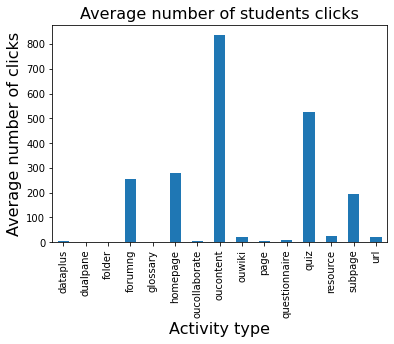

In [17]:
plt.rcParams['figure.dpi'] = 300
params = {'axes.labelsize': 16,
          'axes.titlesize': 16}
plt.rcParams.update(params)


#f14b[['dataplus','dualpane','folder','forumng','glossary','homepage','oucollaborate','oucontent','ouwiki','page','questionnaire','quiz','resource','subpage','url']].mean(axis=0).plot(kind='bar',xlabel='Activity type', ylabel='Average number of clicks', title='Average number of students clicks')
vle_data.mean(axis=0).plot(kind='bar',xlabel='Activity type', ylabel='Average number of clicks', title='Average number of students clicks')



In [18]:
ass_idicators,ass_scores=get_assessments('FFF','2014B',ids,mlen)
ass_idicators=ass_idicators.drop('avg_days',1)
ass_idicators.head(3)

,TMA24,TMA52,TMA87,TMA129,TMA171
id_student,,,,,
26211,0,0,0,0,0
27189,0,0,1,0,0
27683,0,0,0,0,1


In [19]:
len(ass_idicators),len(ass_scores)

(1339, 1204)

In [20]:
ass_scores.head(2)

asstype_date,CMA227,TMA129,TMA171,TMA24,TMA52,TMA87
id_student,,,,,,
26211,98,68,88,84,84,78
27189,69,35,51,52,48,16


In [21]:
data=vle_data.join(ass_idicators).drop(['dualpane','folder','glossary'],axis=1)# according to the figure they are not useful
len(data)

1309

In [22]:
data.head(2)

,dataplus,forumng,homepage,oucollaborate,oucontent,ouwiki,page,questionnaire,quiz,resource,subpage,url,TMA24,TMA52,TMA87,TMA129,TMA171
id_student,,,,,,,,,,,,,,,,,
26211,35,1200,2265,16,8263,84,25,41,1710,80,1052,117,0,0,0,0,0
27189,0,336,280,2,731,3,2,0,923,85,245,25,0,0,1,0,0


In [ ]:
#data2=ass_idicators.join(vle_data) 
#data2[data2.isna().any(axis=1)] used to chect if teh join other way works there were many nan fields so it is  not correct

In [23]:
kmeans_res=kmeans(data)
for k in kmeans_res.keys():
    print(k,kmeans_res[k]['sil'].round(3))

2 0.543
3 0.485
5 0.42


In [24]:
kmeans_res[2]['centroids'].round(3).T

,0,1
dataplus,0.736,13.656
forumng,141.002,518.260
homepage,147.120,593.609
oucollaborate,2.416,7.108
oucontent,362.964,1954.216
ouwiki,10.190,47.437
page,3.707,11.653
questionnaire,2.249,17.560
quiz,339.197,960.661
resource,20.402,41.121


In [25]:
kmeans_res[3]['centroids'].round(3).T

,0,1,2
dataplus,0.225,22.867,6.998
forumng,113.759,755.575,351.102
homepage,109.786,861.027,407.117
oucollaborate,1.948,9.159,5.454
oucontent,235.774,2980.637,1262.382
ouwiki,8.145,77.867,28.205
page,3.366,18.142,7.400
questionnaire,1.340,25.363,10.911
quiz,230.546,1084.248,851.508
resource,16.286,50.195,37.054


In [26]:
k2=kmeans_res[2]['clusters'].join(results)
k2_res=clust_results(k2,2)
print(k2_res)
k3=kmeans_res[3]['clusters'].join(results)
k3_res=clust_results(k3,3)
print(k3_res)

{0: [32.61, 37.07], 1: [91.0, 6.94]}
{0: [20.19, 43.52], 1: [96.46000000000001, 2.65], 2: [85.74, 9.94]}


In [27]:
k2_dic={1:'H',0:'L'}#{1:'L',0:'H'}
k2['eng_level']=k2[2].map(k2_dic)
# k3_dic={2:'H',1:'M',0:'L'}
# k3['eng_level']=k3[3].map(k3_dic)

In [28]:
k2.head(2)
#k3.head(2)

,2,final_result,eng_level
id_student,,,
26211,1,Pass,H
27189,0,Fail,L


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.scatter(data0['forumng'] , data0['oucontent'] , label = 'High Engaged',marker='*')
plt.scatter(data1['forumng'] , data1['oucontent'], label = 'Low Engaged',marker='+')
plt.legend(loc='best')

plt.xlabel('number of forum clicks')
plt.ylabel('number of course contents clicks')
#plt.title('')
plt.show()


In [ ]:
# csv_data=data.join(k2['eng_level']).join(k3['eng_level'],lsuffix='_2', rsuffix='_3').join(results)
# csv_data.head(2)
# csv_data.to_csv('f14b_eng.csv')

In [30]:
#studInfo(mn,mp,remove_withdraw=False,only_ids=False)
mdemo=demo('FFF','2014B').drop('final_result',1)
mdemo.head(2)

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
id_student,,,,,,,,
26211,F,London Region,HE Qualification,20-30%,35-55,0,90,N
26269,M,Yorkshire Region,Lower Than A Level,0-10%,35-55,0,60,N


In [31]:
#len(mdemo),len(k2)
final_data=k2['eng_level'].to_frame().join(mdemo)[mdemo.columns.tolist()+['eng_level']]# change the columns order
#final_data=k2['eng_level'].join(mdemo)
final_data.head(2)

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,eng_level
id_student,,,,,,,,,
26211,F,London Region,HE Qualification,20-30%,35-55,0,90,N,H
27189,F,South Region,Lower Than A Level,10-20,35-55,0,120,N,L


In [32]:
len(k2),len(final_data)

(1309, 1309)

In [33]:
#f14b_rules=run_filter_rules(f14bDemo,clust2_labelsf14b1)
f14bH1,f14bL1=run_filter_rules(final_data)

In [34]:
len(f14bH1),len(f14bL1)

(21, 25)

In [35]:
f14bH1[f14bH1['lift']>1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,H,L
61,"(H, 60, N)",(0),0.18,0.82,0.17,0.95,1.17,0.023978,3.973226,3,True,False
20,"(H, 60)",(0),0.19,0.82,0.18,0.95,1.17,0.025817,3.910264,2,True,False
84,"(H, 60, 0-35, N)",(0),0.11,0.82,0.11,0.95,1.16,0.014785,3.619124,4,True,False
98,"(M, H, 60, N)",(0),0.14,0.82,0.13,0.95,1.16,0.018464,3.543907,4,True,False
46,"(H, 60, 0-35)",(0),0.12,0.82,0.12,0.95,1.16,0.016184,3.508468,3,True,False
59,"(M, H, 60)",(0),0.15,0.82,0.15,0.95,1.16,0.019862,3.462903,3,True,False
71,"(A Level or Equivalent, H, 0)",(N),0.12,0.90,0.11,0.93,1.04,0.003818,1.473387,3,True,False
31,"(H, 0)",(N),0.26,0.90,0.24,0.93,1.04,0.008399,1.473387,2,True,False
42,"(A Level or Equivalent, H)",(N),0.14,0.90,0.13,0.93,1.03,0.003775,1.360050,2,True,False
60,"(0, H, 60)",(N),0.18,0.90,0.17,0.92,1.03,0.004728,1.344877,3,True,False


In [36]:
f14bL1[f14bL1['lift']>1].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,H,L
62,"(L, 60, Lower Than A Level)",(0),0.16,0.82,0.15,0.93,1.14,0.017959,2.590668,3,False,True
86,"(L, 60, 0-35, Lower Than A Level)",(0),0.12,0.82,0.11,0.93,1.13,0.013029,2.468768,4,False,True
101,"(N, L, 60, Lower Than A Level)",(0),0.14,0.82,0.13,0.93,1.13,0.015091,2.439454,4,False,True
100,"(L, 60, M, Lower Than A Level)",(0),0.14,0.82,0.13,0.93,1.13,0.015091,2.439454,4,False,True
104,"(L, A Level or Equivalent, 0, M)",(N),0.21,0.90,0.19,0.92,1.03,0.005095,1.315887,4,False,True
111,"(60, Lower Than A Level, L, N, M)",(0),0.12,0.82,0.11,0.92,1.13,0.012664,2.308602,5,False,True
64,"(L, 60, N)",(0),0.34,0.82,0.31,0.92,1.12,0.034313,2.251423,3,False,True
40,"(L, 90)",(N),0.11,0.90,0.10,0.92,1.02,0.002192,1.247067,2,False,True
88,"(L, 60, 0-35, N)",(0),0.26,0.82,0.24,0.92,1.12,0.025995,2.193847,4,False,True
47,"(L, 60, 0-35)",(0),0.30,0.82,0.27,0.92,1.12,0.028796,2.151821,3,False,True
